In [14]:
# import sys, os
import sys
sys.path.insert(0, '/home/issam/Research_Ground/BlockCoordinateDescent')


from haven import haven_jupyter as hj
from haven import haven_results as hr

# path to where the experiments got saved
# savedir_base = "/mnt/clients/covid19/borgy"
savedir_base = "/mnt/datasets/public/issam/prototypes/bcd/debug"
# savedir_base = "/mnt/clients/covid19/release"
# savedir_base = "/mnt/datasets/public/issam/prototypes/alcf/debug"




rm = hr.ResultManager(exp_list=None, 
                      savedir_base=savedir_base, 
                      verbose=0,
                      has_score_list=0,
                      filterby_list=None,
                       exp_groups='/home/issam/Research_Ground/BlockCoordinateDescent/exp_configs.py',
#                       mode_key='test_mode'
                     )

# dashboard variables
# legend_list = ['active_learning.n_regions', 'optimizer', 'active_learning.name']
# groupby_list = ['optimizer']
# title_list = ['dataset', 'dataset_size', 'max_epoch']
# groupby_list = ['dataset', 'dataset_size']
# legend_list = ['model.name', 'optimizer', 'active_learning.name', 'active_learning.labeling_mode', 'active_learning.n_regions','active_learning.n_mcmc', 
#                'active_learning.n_regions']_wez

title_list = ['dataset.name']
# val_dict['dice'] = np.mean(list(self.dice_dict.values())) / self.n_samples
#             val_dict['jaccard'] = np.mean(list(self.jaccard_dict.values())) / self.n_samples
#             # val_dict['hausdorff_score_dict'] = np.mean(self.hausdorff_score_dict.values()) / self.n_samples
#             val_dict['precision'] = np.mean(list(self.precision_score_dict.values())) / self.n_samples
#             val_dict['recall'] = np.mean(list(self.recall_score_dict.values())) / self.n_samples
#             val_dict['specificity'] = np.mean(list(self.specificity_score.values())) / self.n_samples
#             val_dict['accuracy']
y_metrics  = []
y_metrics = ['loss']
log_metric_list = ['train_loss']
x_metric = 'iteration'

# launch dashboard
exp_group = '1_upper_bound_issam'
# exp_group = '2_random_vs_entropy_old'
# exp_group = '3_weakly_rect'
exp_group = 'fig4'
figsize = (30, 8)

# filter
groupby_list = ['dataset']
# groupby_list = None
groupby_list = ['model']
filterby_list = ( 'model.loss', 'dice')
legend_list = ['partition', 'selection',  'update']
legend_format = '{}-{}-{}'
filterby_list = ('active_learning.name', 'entropy')
filterby_list=None
hj.get_dashboard(rm, vars(), wide_display=True)


100%|██████████| 1344/1344 [00:01<00:00, 785.04it/s]


<IPython.core.display.Javascript object>

Output()

In [11]:
import sys
sys.path.insert(0, '/home/issam/Research_Ground/BlockCoordinateDescent')
savedir_base = "/mnt/datasets/public/issam/prototypes/bcd/debug"
from haven import haven_jupyter as hj
from haven import haven_results as hr
from src.base import plot
import pandas as pd
import numpy as np
import pylab as plt
# import sys, os

from src.base import utils as ut
def filter_exp_list(exp_list):
    # Ignore the following combinations
    exp_list_new = []
    for exp_dict in exp_list:
        if ((exp_dict['partition'] != "VB" and exp_dict['selection'] == "BGSC") or
            (exp_dict['partition'] != "VB" and exp_dict['selection'] == "OMP") or
            (exp_dict['partition'] == "VB" and exp_dict['selection'] == "GSQ") or
            (exp_dict['partition'] != "VB" and "GSQ-" in exp_dict['selection']) or
            (exp_dict['partition'] != "VB" and exp_dict['selection'] == "GSC") or
            (exp_dict['partition'] != "VB" and exp_dict['selection'] == "Perm") or
            (exp_dict['partition'] == "VB" and exp_dict['selection'] == "BGSL") or
            (exp_dict['partition'] == "VB" and exp_dict['selection'] == "GSL") or
            (exp_dict['partition'] == "VB" and exp_dict['selection'] == "cCyclic")or
            (exp_dict['partition'] != "VB" and exp_dict['selection'] == "IHT")or
            (exp_dict['partition'] != "VB" and exp_dict['selection'] == "GSDHb")):
            continue
        exp_list_new += [exp_dict]
        
    return exp_list_new


def get_one_plot(exp_list, savedir_base, plot_names=None):
    traceList = []
    p_rules=np.unique([e['partition'] for e in exp_list])
    s_rules =np.unique([e['selection'] for e in exp_list])
    u_rules = np.unique([e['update'] for e in exp_list])
        
    score_list_list = hr.get_score_lists(exp_list, savedir_base)
    assert(len(exp_list)== len(score_list_list))
    for exp_dict, score_list in zip(exp_list, score_list_list):
        # single figure
        legend = 'Yes'
        score_df = pd.DataFrame(score_list)
        
        if "converged" in score_df.columns:
          ind = np.where(np.isnan(np.array(score_df["converged"])))[0][-1] + 1
          converged = {"Y":score_df["converged"][ind],
                       "X":ind}
        else:
          converged = None
        
        
        
        legend = ut.legendFunc(exp_dict['partition'], exp_dict['selection'], exp_dict['update'], 
                               p_rules, s_rules, u_rules, plot_names=plot_names)
        trace = {"Y":np.array(score_df["loss"]), 
                                   "X":np.array(score_df["iteration"]),
                                   "legend":legend,
                                   "converged":converged}
        traceList += [trace]
    return traceList

def get_dataset_plots(exp_list, plot_names):
    figureList = []
    
    loss_name = exp_list[0]['dataset']['loss']
    dataset = exp_list[0]['dataset']['name'].upper()
    xlabel = 'Iterations'
    
    exp_list_list = hr.group_exp_list(exp_list, groupby_list=['block_size'])
    exp_list_list.sort(key=lambda x:x[0]['block_size'])
    # across blocks
    for exp_list_bs in exp_list_list:
        block_size = exp_list_bs[0]['block_size']
        if block_size == -1:
            xlabel = "Iterations"
        else:
            xlabel = "Iterations with |b|=%d" % block_size
                
        trace_list = get_one_plot(exp_list_bs, savedir_base, plot_names=plot_names)
        figureList +=  [{'traceList':trace_list,
                          "xlabel":xlabel,
                          "ylabel":("$f(x) - f^*$ for %s on Dataset %s" % 
                                         (loss_name, dataset)),
                          "yscale":"log"}]
    return figureList

from haven import haven_utils as hu
def plot_score_list_list(exp_list, savedir_base, exp_name, plot_names=None):
    exp_list = filter_exp_list(exp_list)
    trace_list = []
    meta_list = []
    
    
    exp_list_list = hr.group_exp_list(exp_list, groupby_list=['dataset'])
    
    plotList = []
    
    # across dataset
    for exp_list_dataset in exp_list_list:
        plotList += [get_dataset_plots(exp_list_dataset, plot_names)]
        
    fig = plot.plot(plotList, expName=exp_name,  legend_size=8, axTickSize=11,markersize=8, axFontSize=14,
                    linewidth=1, 
        box_linewidth=1, savedir_base='/home/issam/Research_Ground/BlockCoordinateDescent/figures', fname=1)
    return fig


exp_config_fname = '/home/issam/Research_Ground/BlockCoordinateDescent/exp_configs.py'

def get_exp_list_from_config(exp_groups, exp_config_fname):
    exp_list = []
    for e in exp_groups:
        exp_list += hu.load_py(exp_config_fname).EXP_GROUPS[e]
    return exp_list



fig4a saved.
fig4b saved.
fig4c saved.
fig5a saved.
fig5b saved.
fig5c saved.
fig6a saved.
fig6b saved.
fig7 saved.


/home/issam/Research_Ground/BlockCoordinateDescent/src/base/pretty_plot.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/home/issam/Research_Ground/BlockCoordinateDescent/src/base/pretty_plot.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/home/issam/Research_Ground/BlockCoordinateDescent/src/base/pretty_plot.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expli

fig8 saved.


/home/issam/Research_Ground/BlockCoordinateDescent/src/base/pretty_plot.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/home/issam/Research_Ground/BlockCoordinateDescent/src/base/pretty_plot.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/home/issam/Research_Ground/BlockCoordinateDescent/src/base/pretty_plot.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expli

fig9 saved.


/home/issam/Research_Ground/BlockCoordinateDescent/src/base/pretty_plot.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/home/issam/Research_Ground/BlockCoordinateDescent/src/base/pretty_plot.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/home/issam/Research_Ground/BlockCoordinateDescent/src/base/pretty_plot.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expli

fig10 saved.


/home/issam/Research_Ground/BlockCoordinateDescent/src/base/pretty_plot.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/home/issam/Research_Ground/BlockCoordinateDescent/src/base/pretty_plot.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/home/issam/Research_Ground/BlockCoordinateDescent/src/base/pretty_plot.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expli

fig11 saved.


/home/issam/Research_Ground/BlockCoordinateDescent/src/base/pretty_plot.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/home/issam/Research_Ground/BlockCoordinateDescent/src/base/pretty_plot.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/home/issam/Research_Ground/BlockCoordinateDescent/src/base/pretty_plot.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expli

fig12 saved.


/home/issam/Research_Ground/BlockCoordinateDescent/src/base/pretty_plot.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/home/issam/Research_Ground/BlockCoordinateDescent/src/base/pretty_plot.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/home/issam/Research_Ground/BlockCoordinateDescent/src/base/pretty_plot.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expli

fig13 saved.


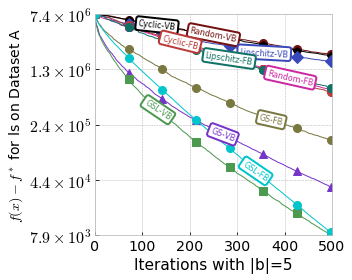

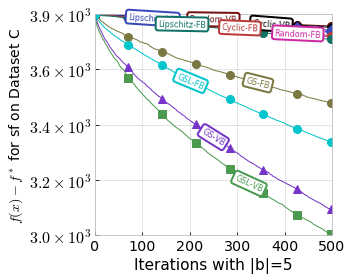

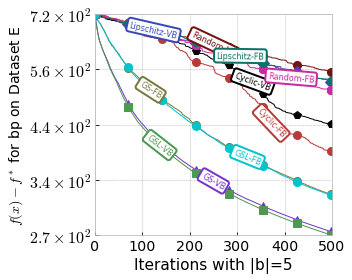

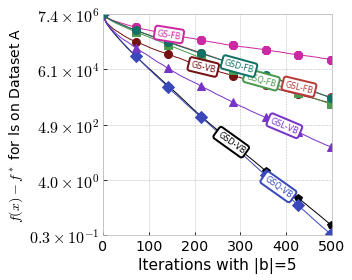

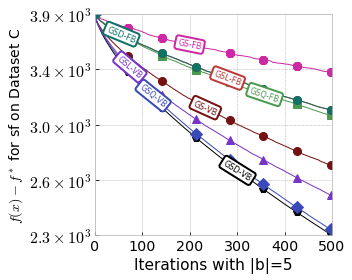

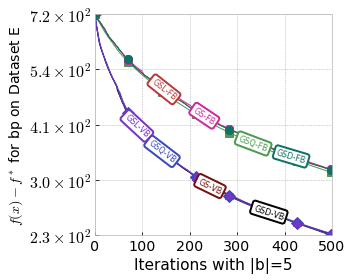

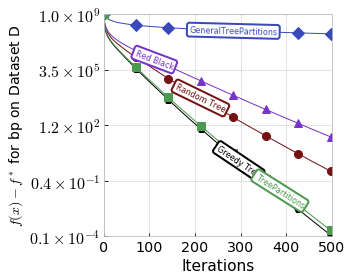

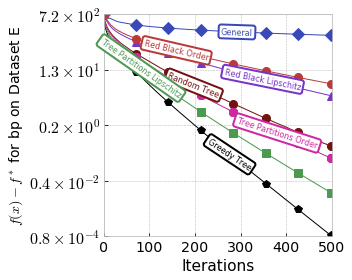

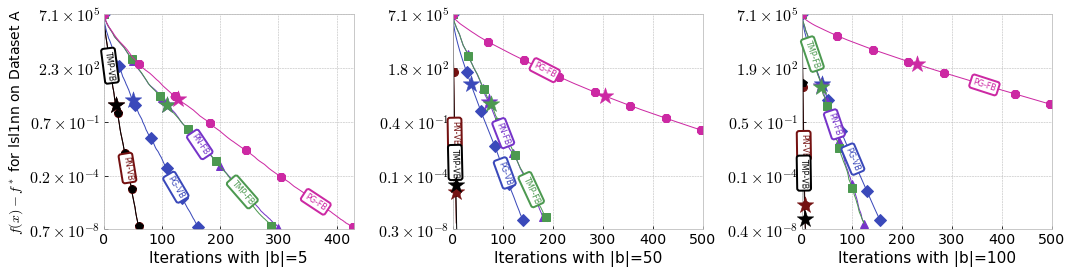

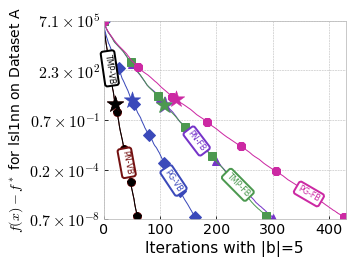

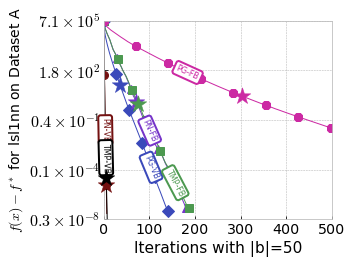

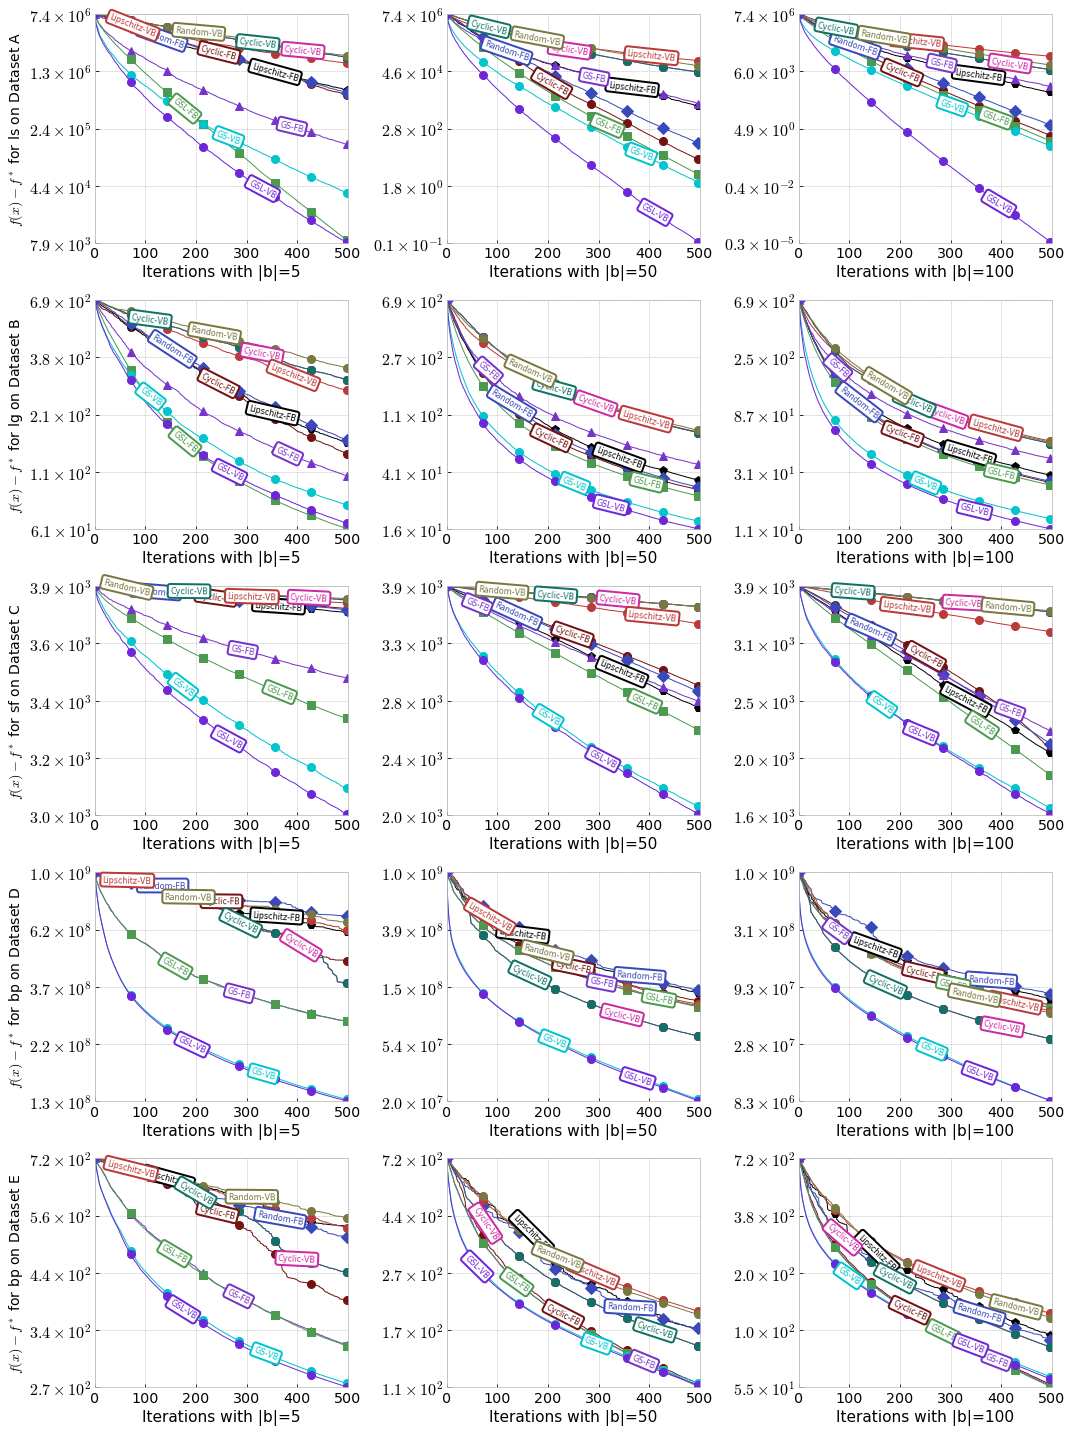

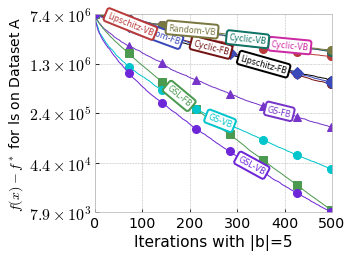

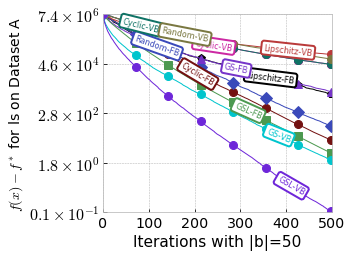

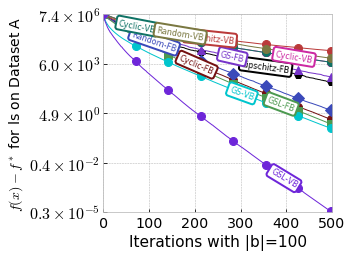

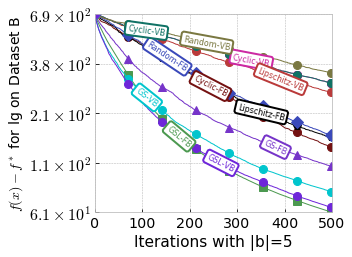

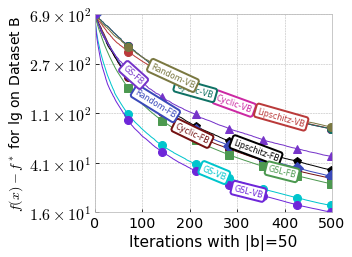

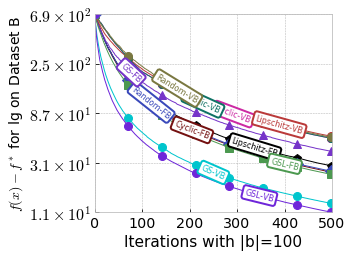

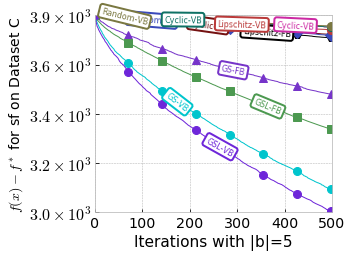

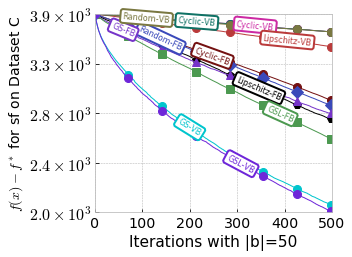

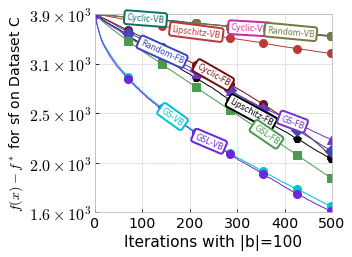

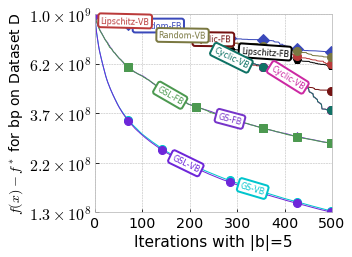

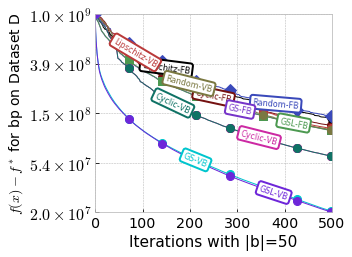

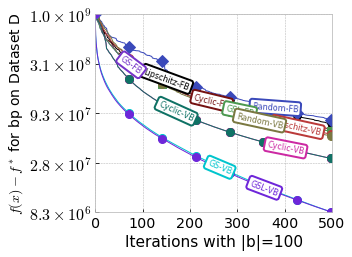

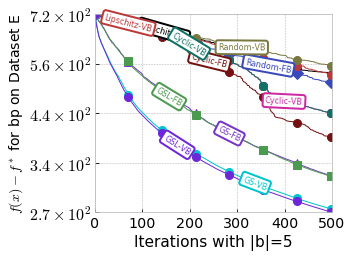

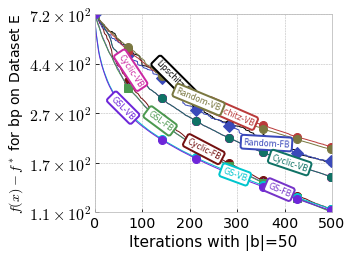

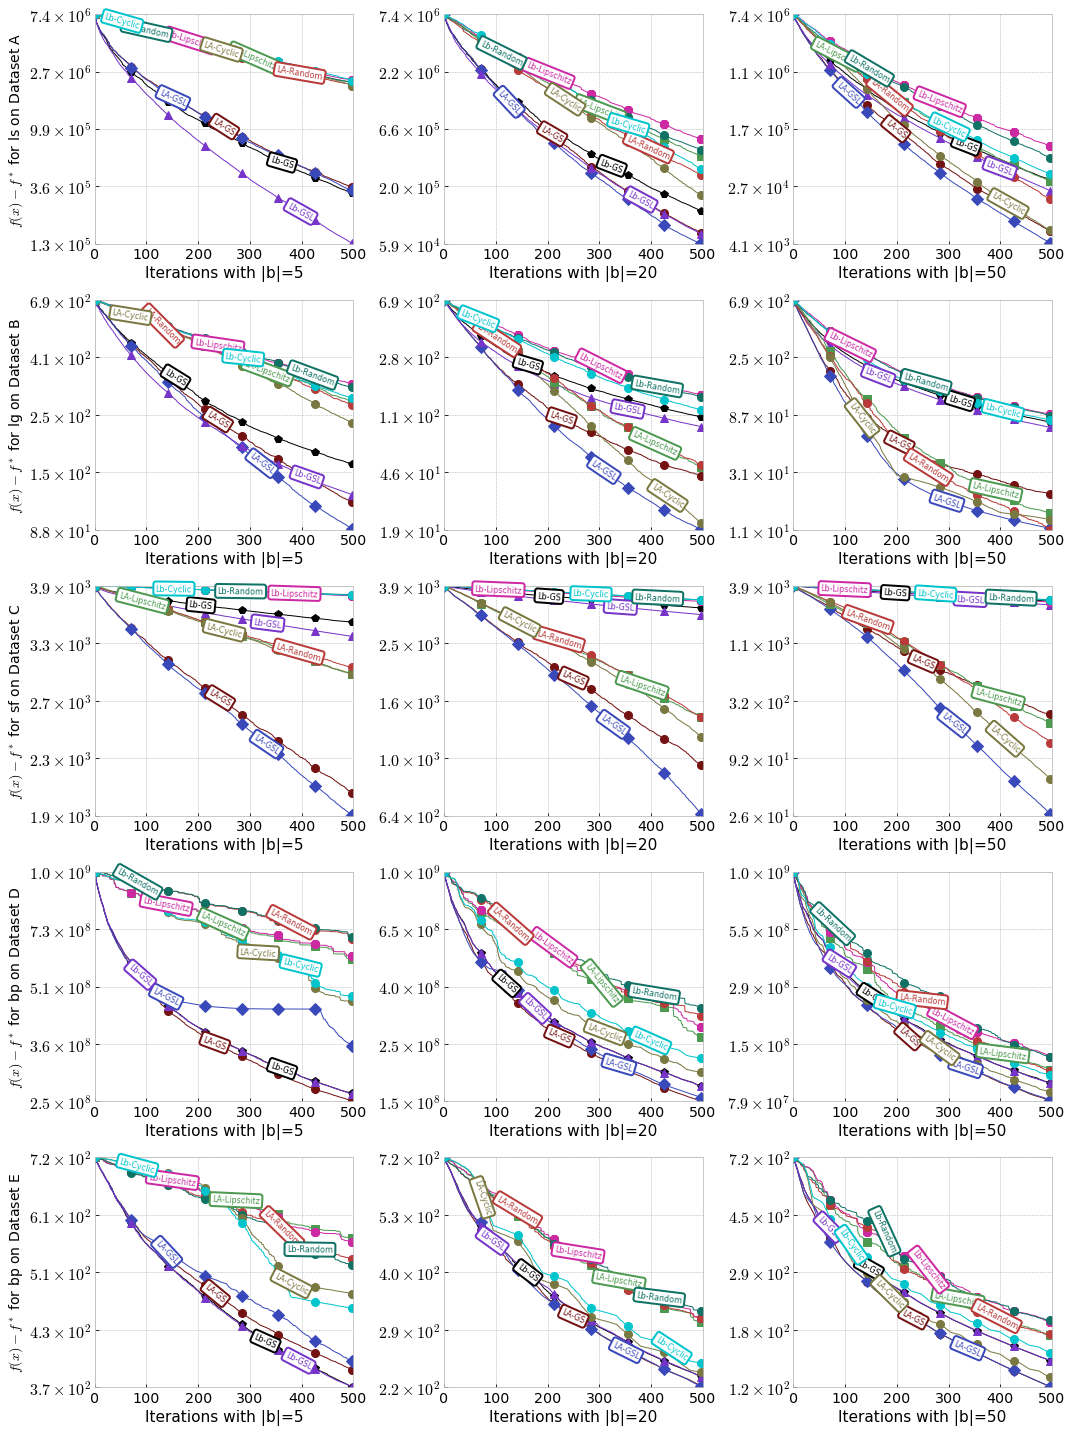

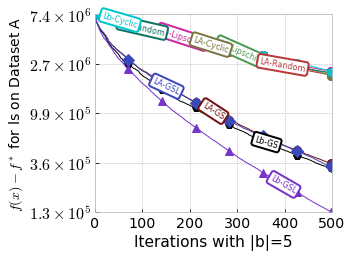

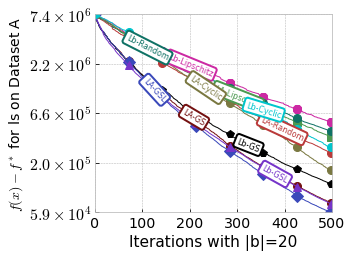

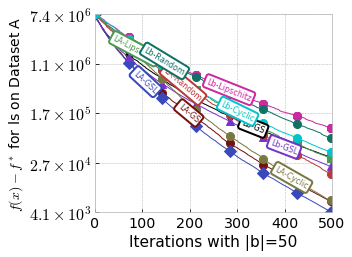

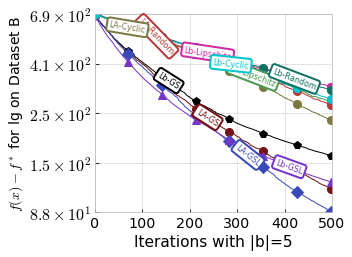

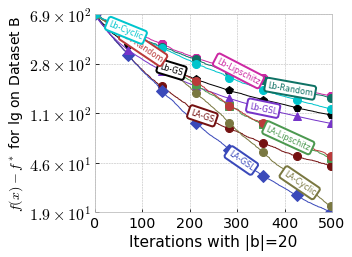

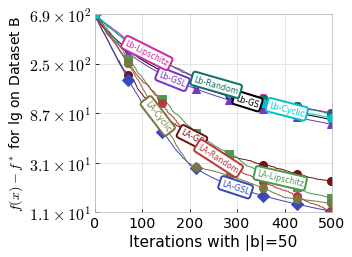

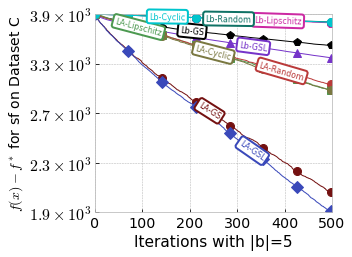

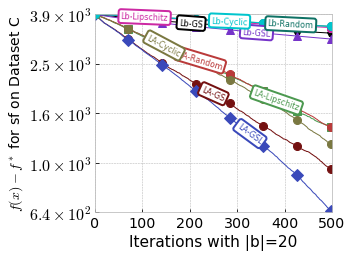

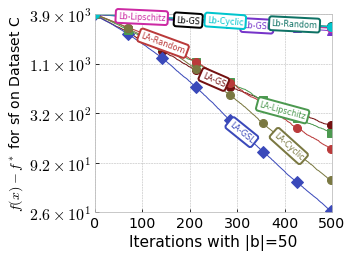

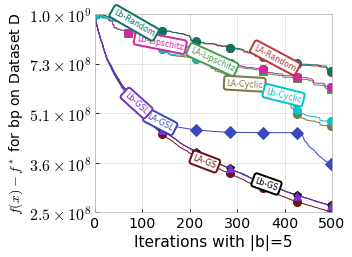

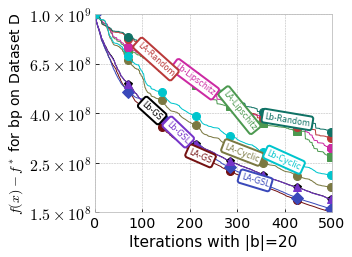

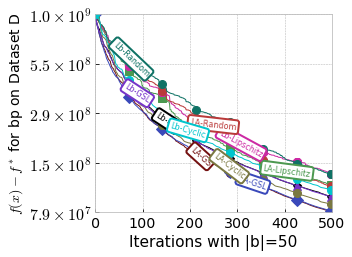

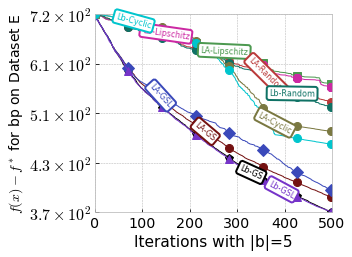

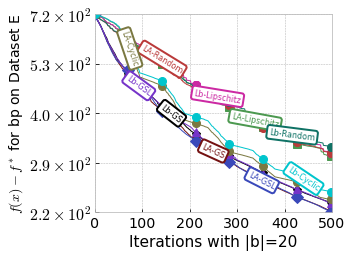

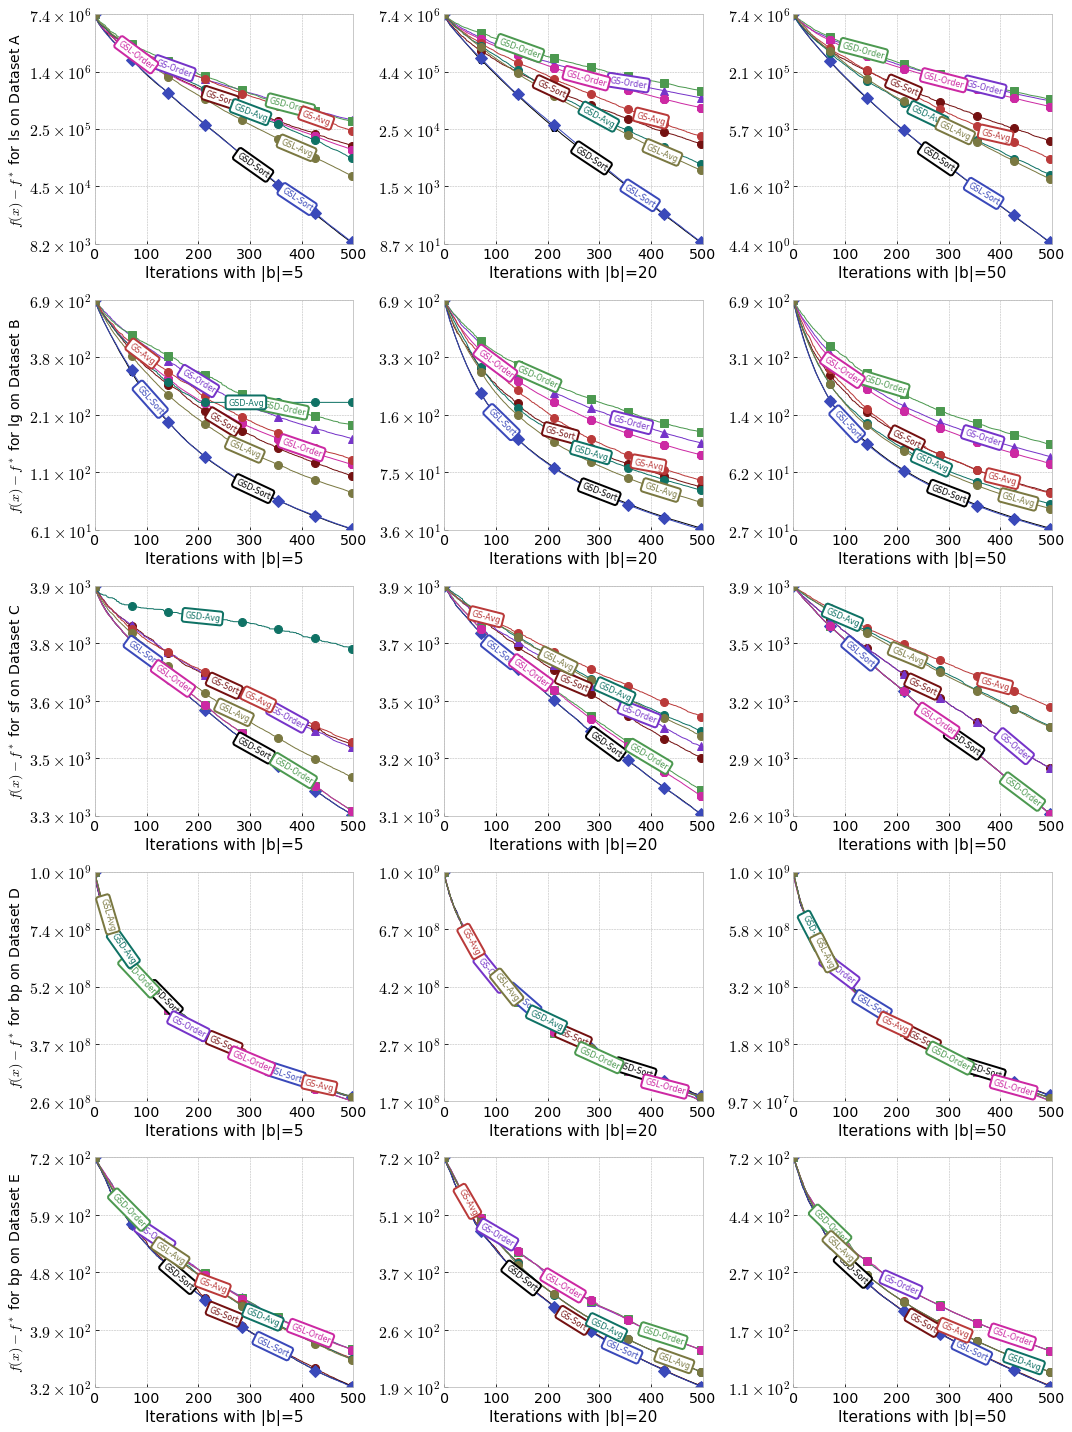

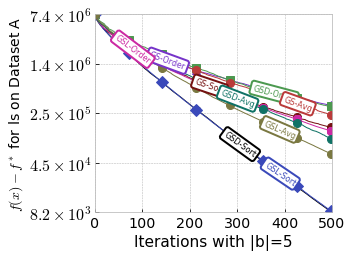

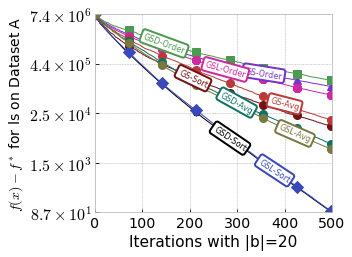

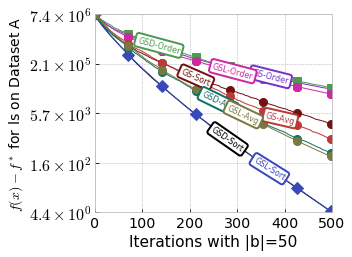

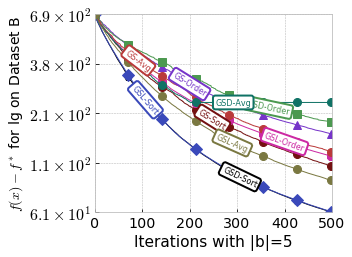

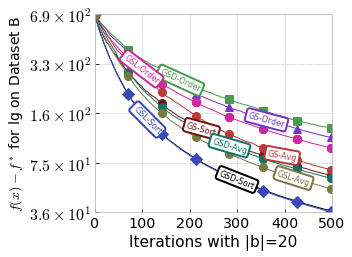

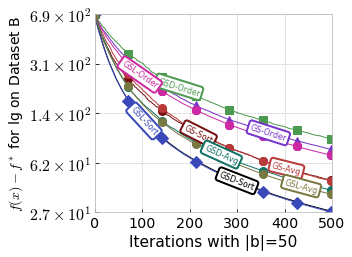

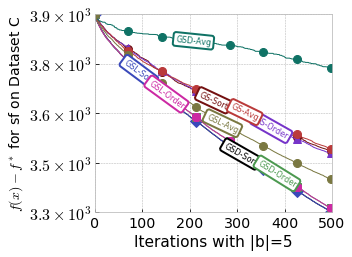

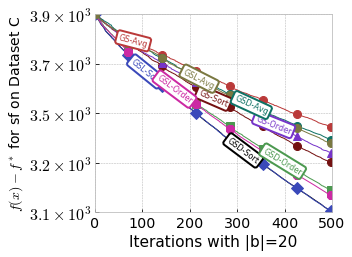

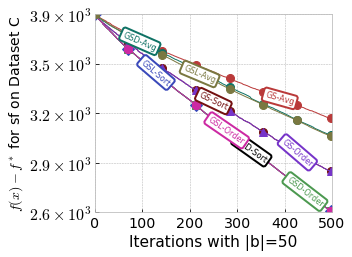

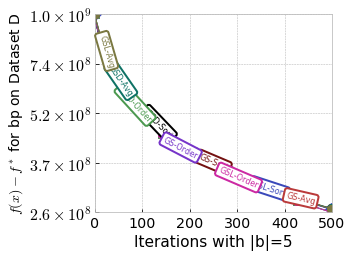

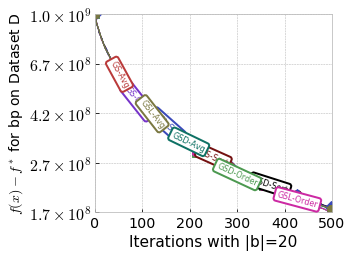

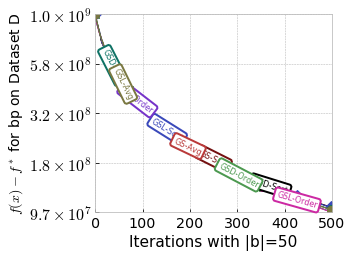

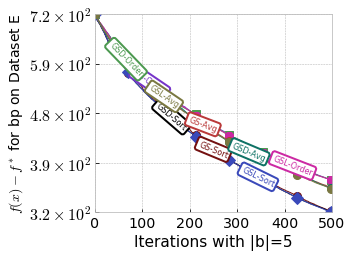

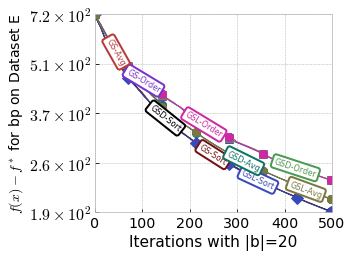

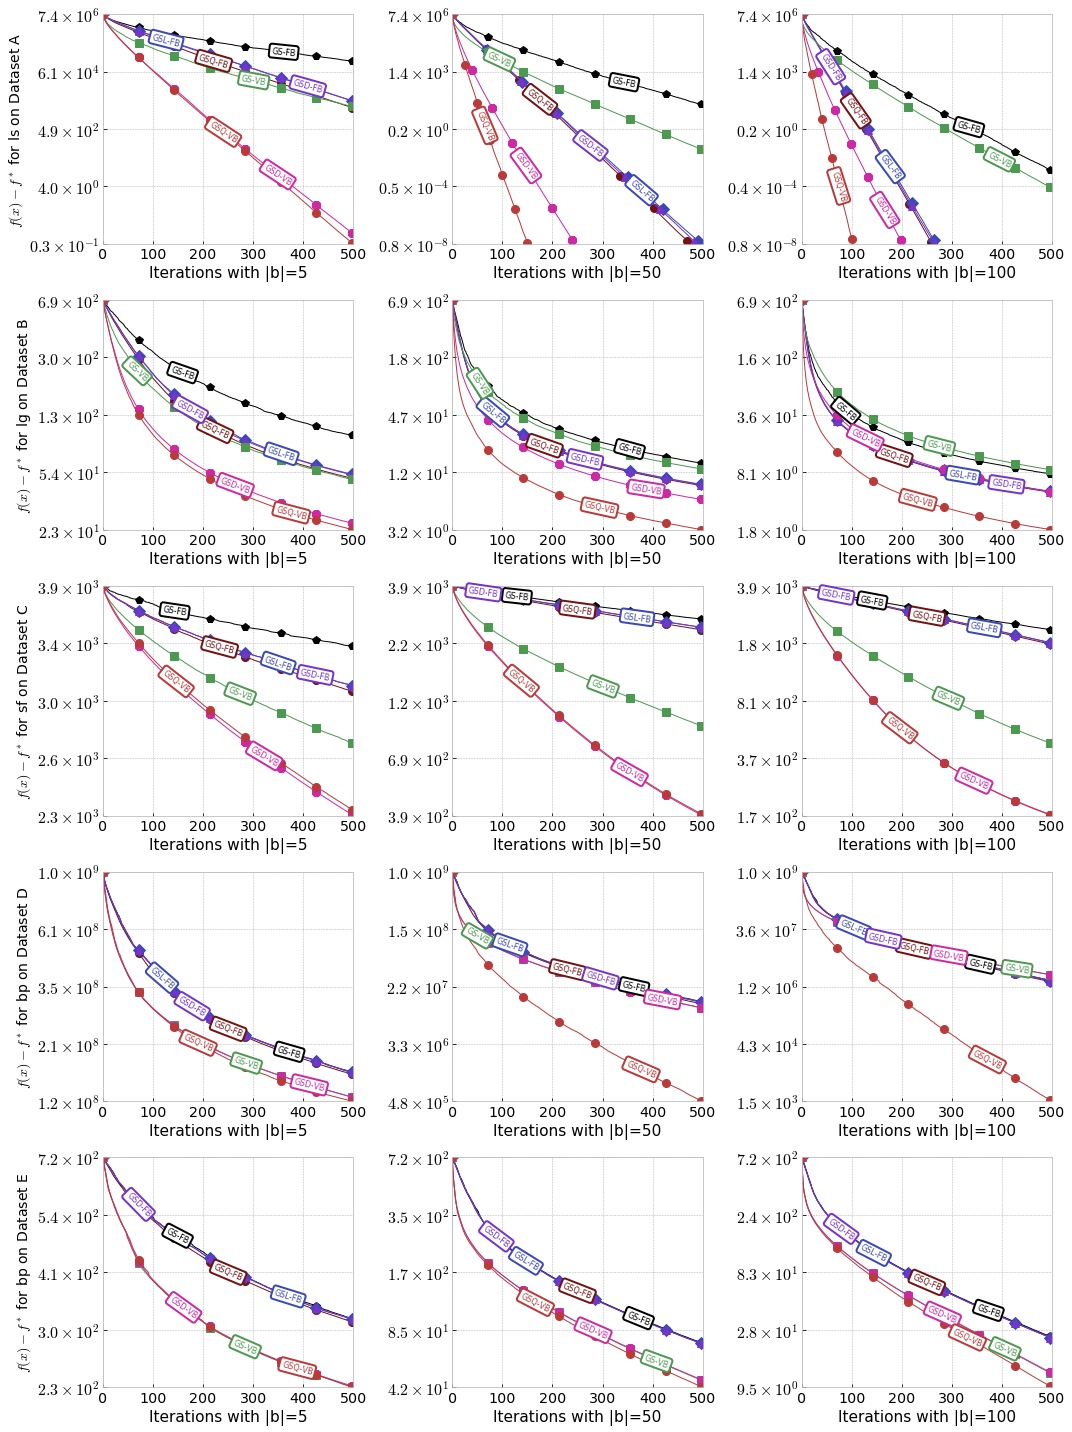

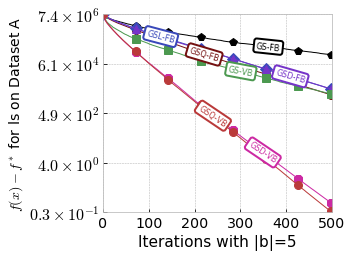

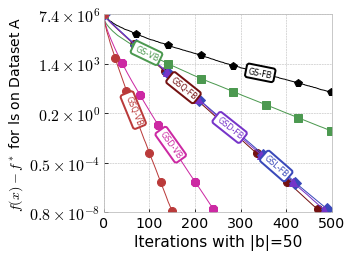

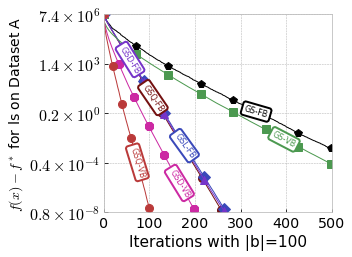

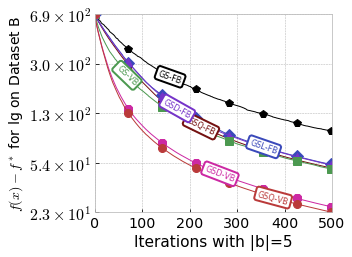

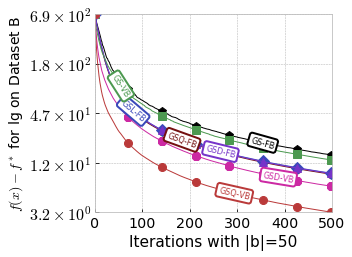

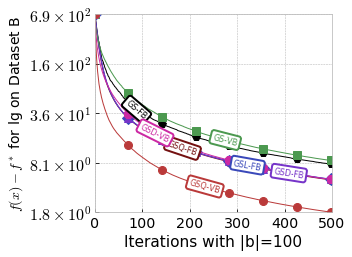

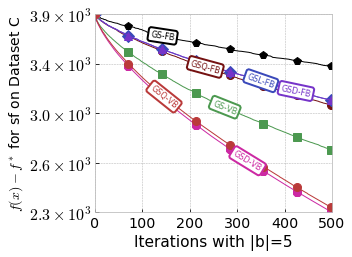

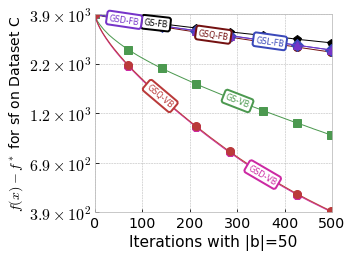

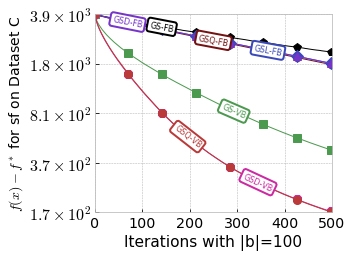

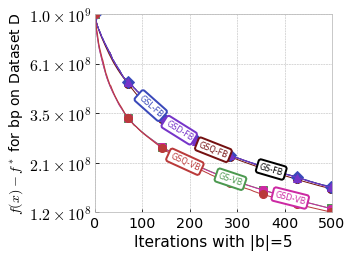

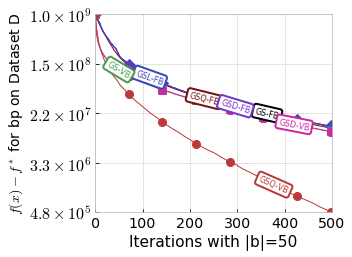

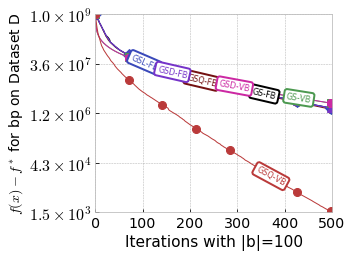

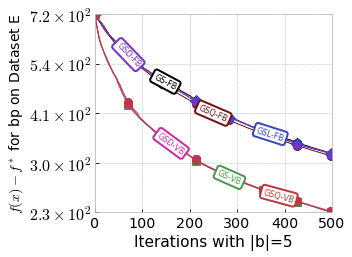

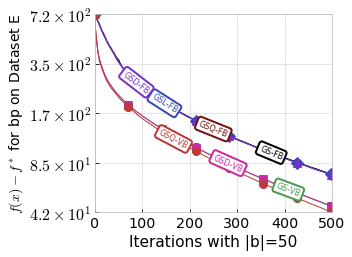

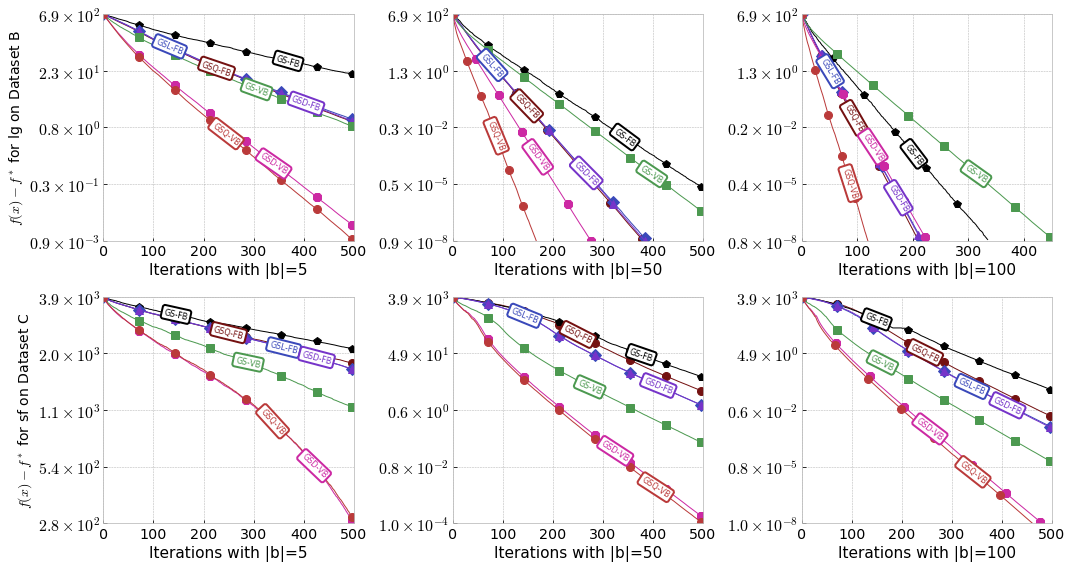

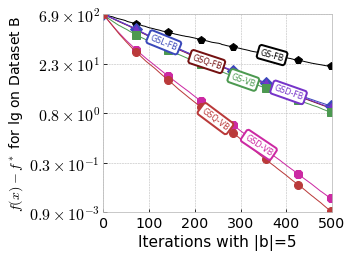

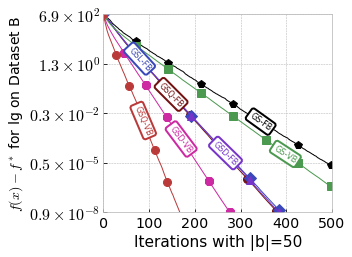

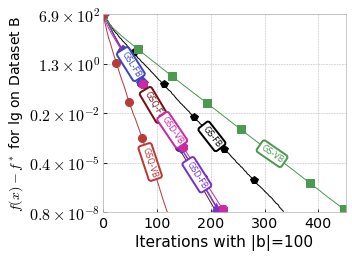

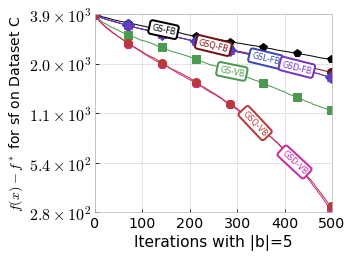

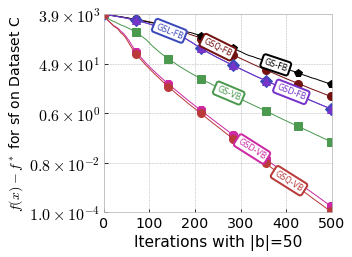

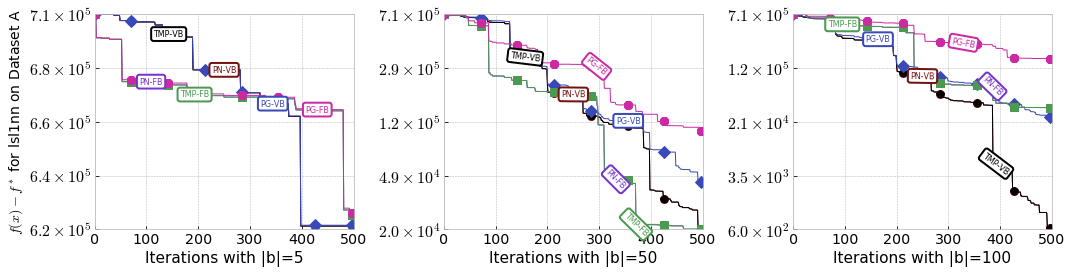

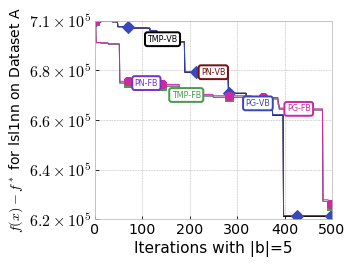

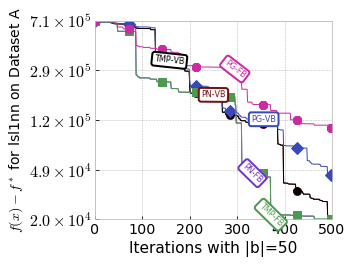

In [13]:
fig4_pn = ['Sort:FB', 'GSDHb:GSL']
fig5_pn = ['Sort:FB', 'IHT:GSQ', 'GSDHb:GSL']
fig6a_pn = ["GSExactTree:General" 
    "TreePartitions:Tree Partitions",
     "RedBlackTree:Red Black",
     "GSTree:Greedy Tree",
     "RTree:Random Tree"]
fig6b_pn = ['GSExactTree:General',
               'TreePartitions:Tree Partitions Lipschitz',
     'RedBlackTree:Red Black Lipschitz',
               'GSTree:Greedy Tree',
     'RTree:Random Tree',
               'TreePartitionsRandom:Tree Partitions Order',
     'RedBlackTreeRandom:Red Black Order']

for exp_name, plot_names in [
    ('fig4a', fig4_pn),
    ('fig4b', fig4_pn),
    ('fig4c', fig4_pn),
    
    ('fig5a', fig5_pn),
    ('fig5b', fig5_pn),
    ('fig5c', fig5_pn),
    
     ('fig6a', fig6a_pn),
    
    ('fig6b', fig6b_pn),
    
    ('fig7', ['Sort:FB', 'qp-nn:PN', 'TMP-NN:TMP', 'Lb-NN:PG']),
     ('fig8', ['Sort:FB', 'Perm:Cyclic', 'GSDHb:GSL']),
     ('fig9', ['Sort:FB']),
     ('fig10', None),
            ('fig11', ['Sort:FB', 'IHT:GSQ']),
    ('fig12', ['Sort:FB', 'IHT:GSQ']),
    ('fig13', ['Sort:FB', 'qp-nn:PN', 'TMP-NN:TMP', 'Lb-NN:PG'])
]:
    fig = plot_score_list_list(form_exp_list([exp_name], exp_config_fname), savedir_base, exp_name=exp_name, plot_names=plot_names)
    plt.close()
    print(exp_name, 'saved.')




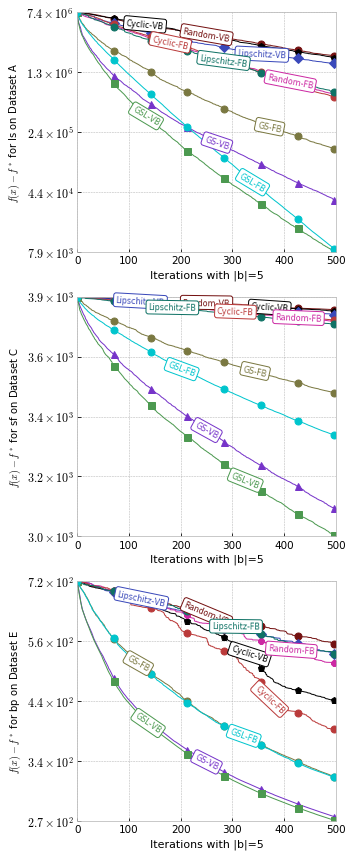

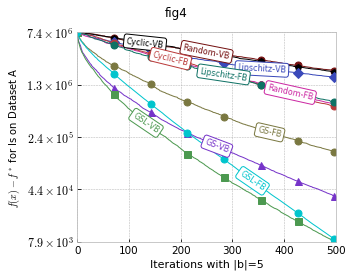

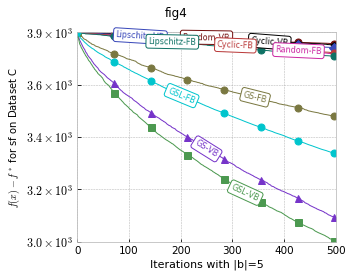

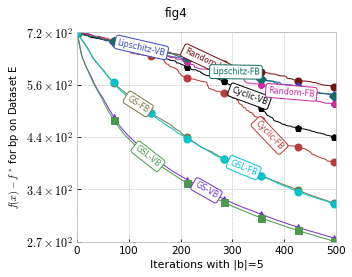

In [4]:
exp_name = 'fig4'
plot_names =  ['Sort:FB', 'GSDHb:GSL']
fig = plot_score_list_list(form_exp_list([exp_name], exp_config_fname), savedir_base, exp_name=exp_name, plot_names=plot_names)
print()

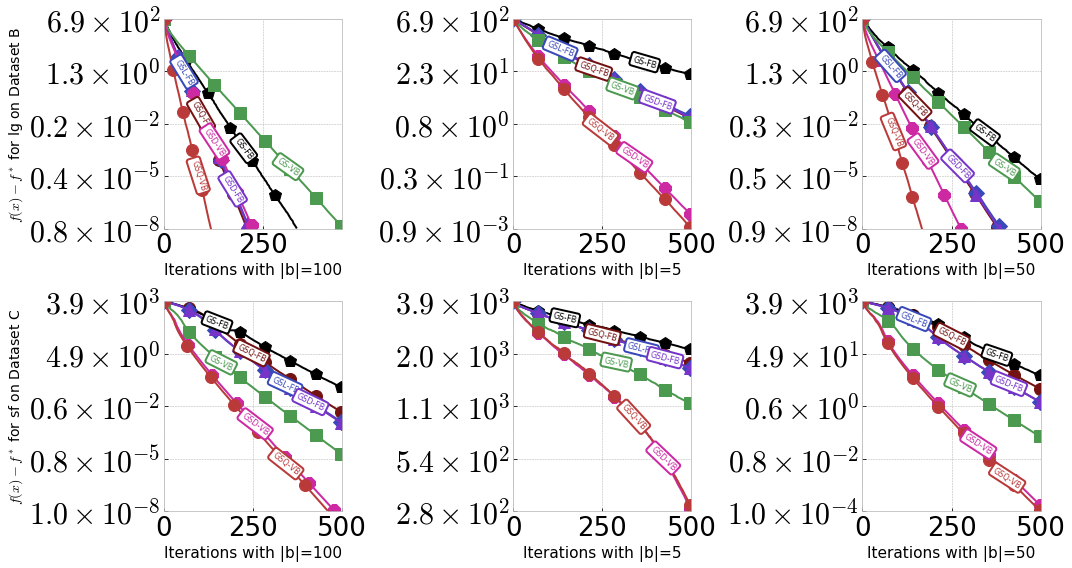

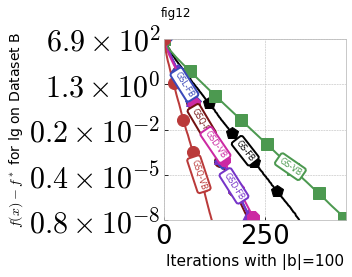

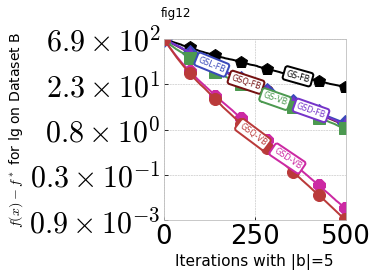

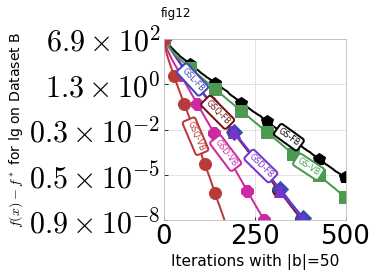

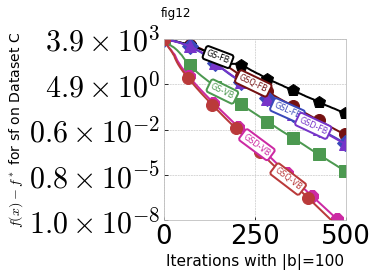

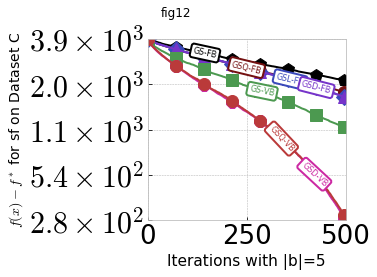

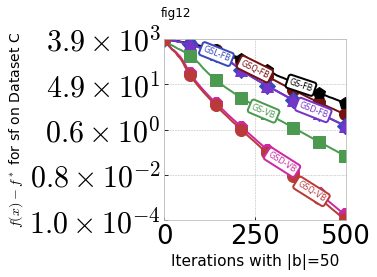

In [10]:
score_lists = rm.get_score_lists()

In [11]:
score_lists[0]

[{'loss': 7432768.210714591,
  'iteration': 0,
  'selected': array([], dtype=float64)},
 {'loss': 7408856.453403558,
  'iteration': 1,
  'selected': array([3850, 3886, 4962, 5437, 9953])},
 {'loss': 7382047.8597620055,
  'iteration': 2,
  'selected': array([  72, 3620, 5919, 7827, 9203])},
 {'loss': 7374292.623009904,
  'iteration': 3,
  'selected': array([1827, 3078, 3234, 4687, 6260])},
 {'loss': 7353410.375764029,
  'iteration': 4,
  'selected': array([3566, 6590, 6720, 8546, 9843])},
 {'loss': 7346789.916310342,
  'iteration': 5,
  'selected': array([ 105, 1325, 5136, 7139, 7310])},
 {'loss': 7339110.780071772,
  'iteration': 6,
  'selected': array([2699, 2714, 9208, 9665, 9768])},
 {'loss': 7315055.286628295,
  'iteration': 7,
  'selected': array([ 484, 1115, 1620, 2738, 3489])},
 {'loss': 7305208.927057199,
  'iteration': 8,
  'selected': array([1575, 1777, 3489, 5650, 9180])},
 {'loss': 7304037.880671508,
  'iteration': 9,
  'selected': array([1028, 3578, 6700, 6904, 8702])},
 {